In [1]:
import sys, os
everestPath = os.path.abspath('everest')
if not everestPath in sys.path:
    sys.path.insert(0, everestPath)

from functools import reduce
import operator
import math
import numpy as np
import scipy as sp
import pandas as pd
import sklearn

from everest.h5anchor import Reader, Fetch
F = lambda key: Fetch(f"*/{key}")
reader = Reader('obsvisc', '.')

from everest.window import Canvas
from everest.window.data import DataChannel
from matplotlib.pyplot import get_cmap
from IPython.display import Video
from everest.window.raster import animate
%matplotlib inline

paramKeys = ('f', 'aspect', 'tauRef', 'temperatureField')
params = dict()
for key in paramKeys:
    params[key] = sorted(set(reader[f"*/{key}"].values()))
params

tauLogs = tuple(math.log10(tau) for tau in params['tauRef'])
minTau, maxTau = min(tauLogs), max(tauLogs)
normTau = lambda tau: (math.log10(tau) - minTau) / (maxTau - minTau)

sinuKeys = ('_built_peaskauslu-thoesfthuec', '_built_oiskeaosle-woatihoo')
sinuFetches = tuple(F('temperatureField') == k for k in sinuKeys)
copyKeys = tuple(
    k for k in params['temperatureField']
        if not k in sinuKeys
    )
copyFetches = tuple(F('temperatureField') == k for k in copyKeys)

sinuModels = reader[reduce(operator.__or__, sinuFetches)]
copyModels = reader[reduce(operator.__or__, copyFetches)]

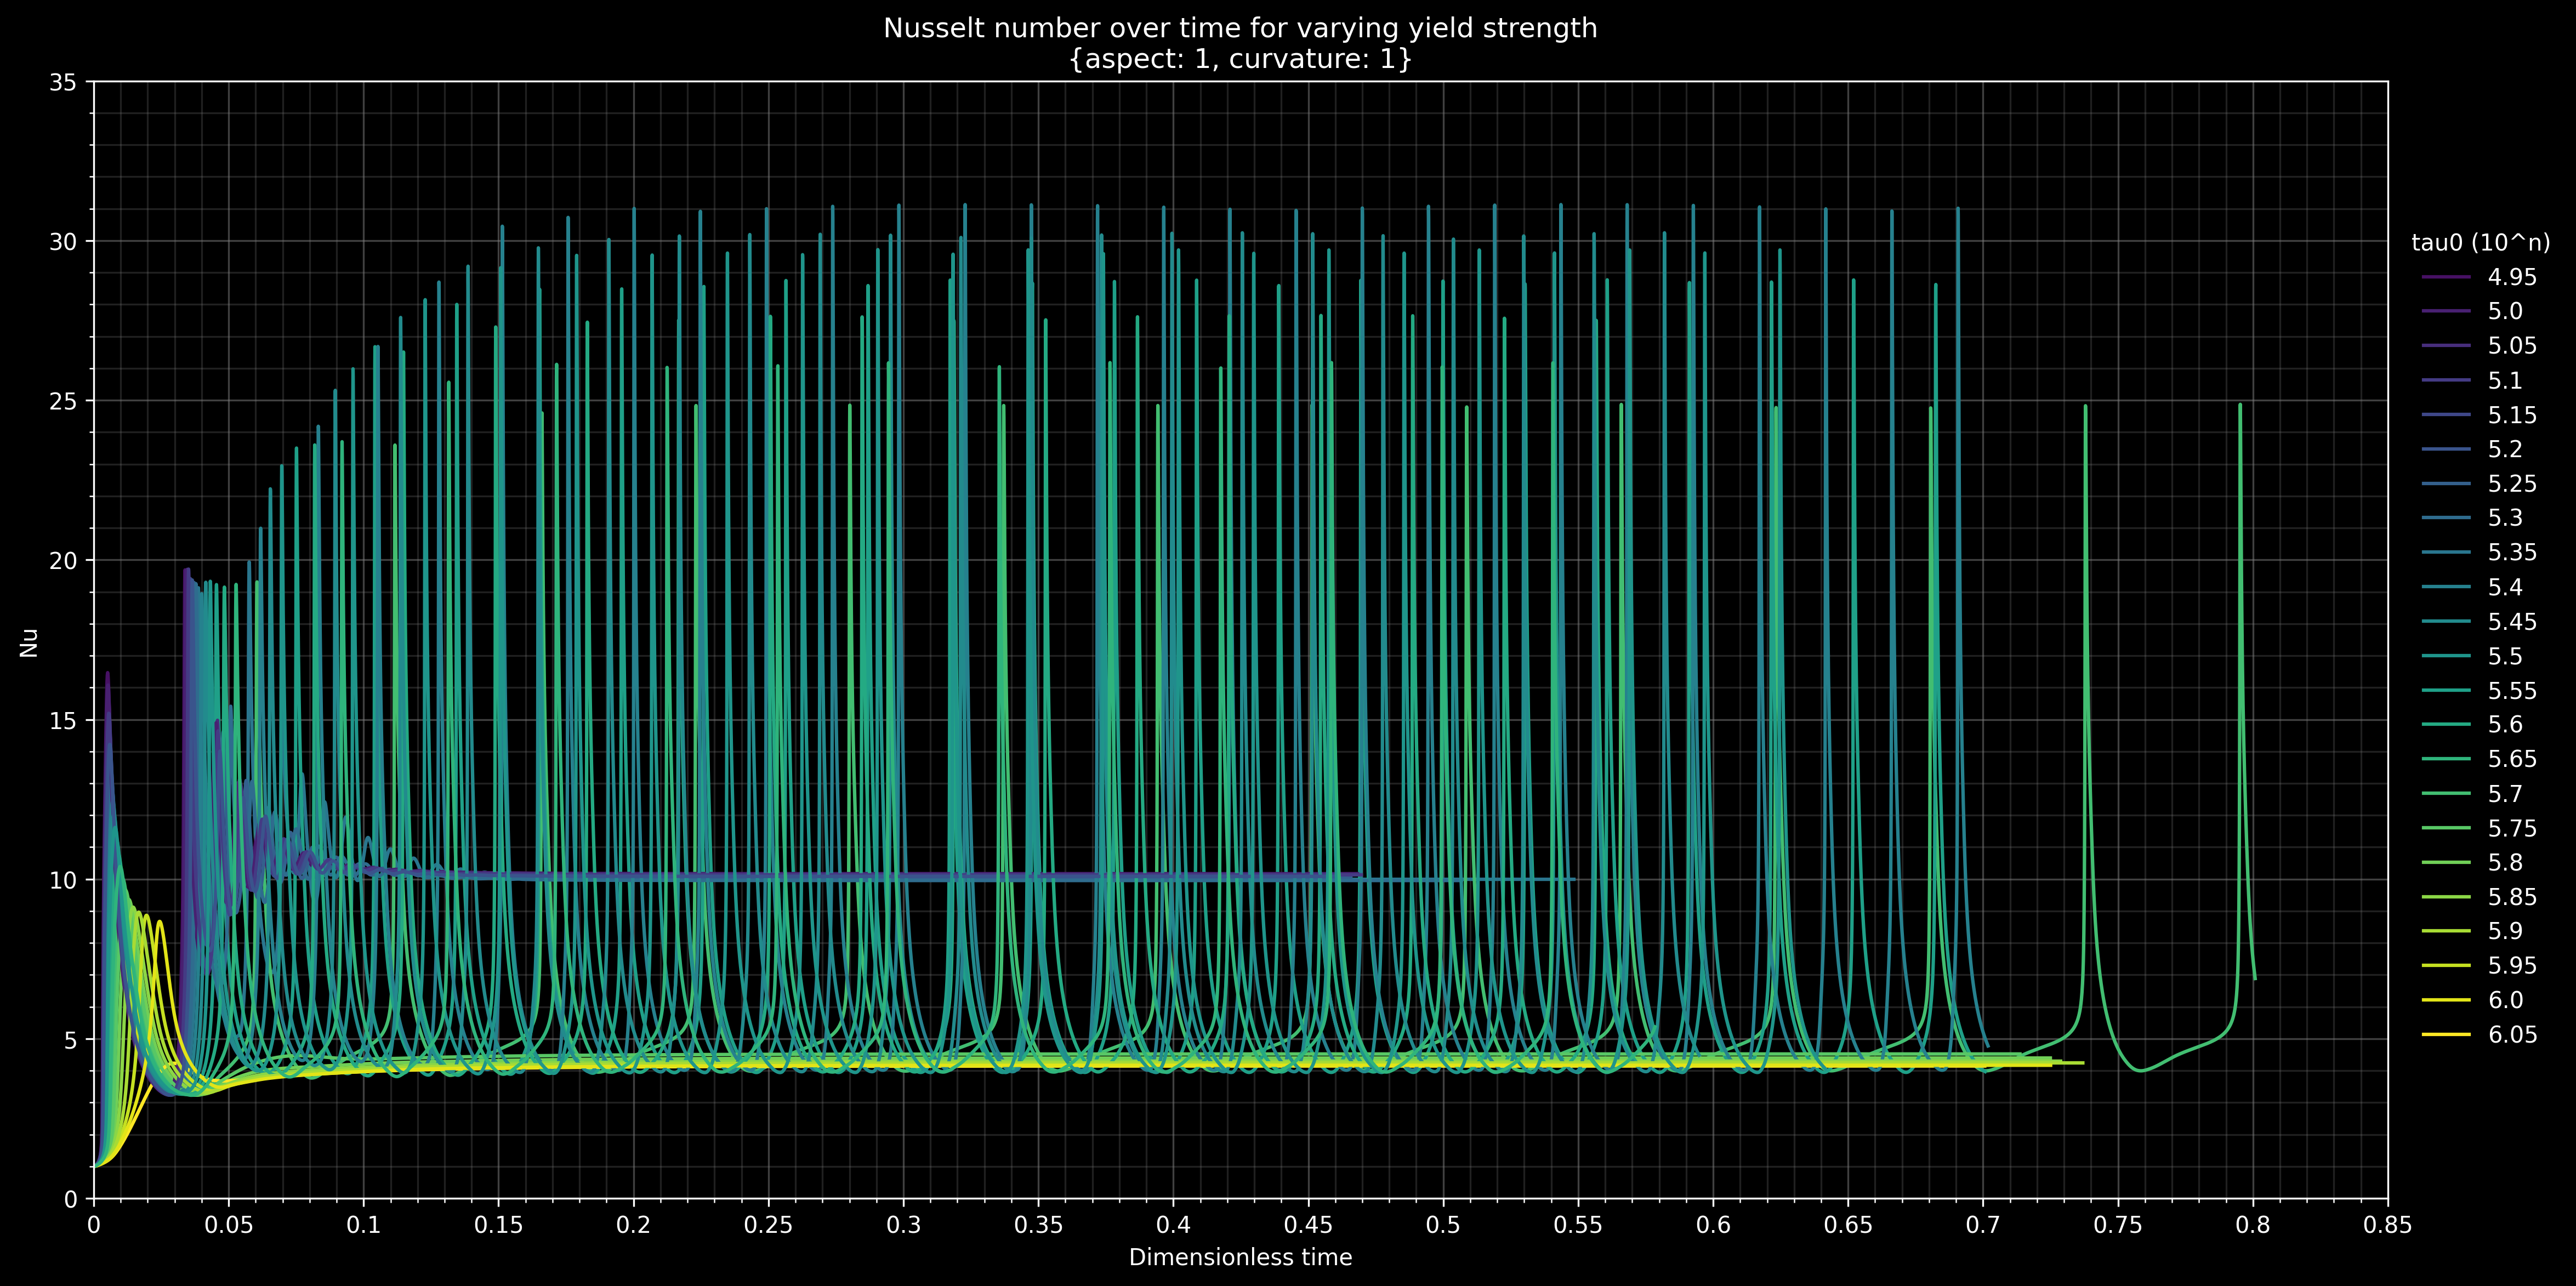

In [2]:
conds = (
    F('aspect') == 1,
    F('f') == 1,
    F('temperatureField') == '_built_peaskauslu-thoesfthuec',
    )
cut = reader[reduce(operator.__and__, conds)]
datas = reader[cut : ('tauRef', 't', 'Nu')]

canvas = Canvas(
    size = (18, 9),
    dpi = 300,
    facecolour = 'black',
    )
ax = canvas.make_ax()
cmap = get_cmap('viridis')
for k, (tauRef, t, Nu) in datas.items():
    if not len(t): continue
    ax.line(
        DataChannel(t, label = 'Dimensionless time'),
        DataChannel(Nu, label = 'Nu'),
        c = cmap(normTau(tauRef)),
        )

ax.axes.title = '\n'.join((
    "Nusselt number over time for varying yield strength",
    "{aspect: 1, curvature: 1}",
    ))
ax.grid.colour = 'grey'
ax.ticks.colour = 'white'
ax.axes.colour = 'white'

legendValues = [math.log10(r[0]) for r in datas.values()]
legendHandles = [r[0] for r in ax.collections]
legendLabels = [str(v) for v in legendValues]
handles, labels, _ = zip(*sorted(zip(legendHandles, legendLabels, legendValues), key = lambda r: r[-1]))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 0.,
    labelcolor = 'white',
    title = 'tau0 (10^n)',
    bbox_to_anchor = (1.08, 0.5),
    )
legend.properties()['title'].set_color('white')

canvas.show()

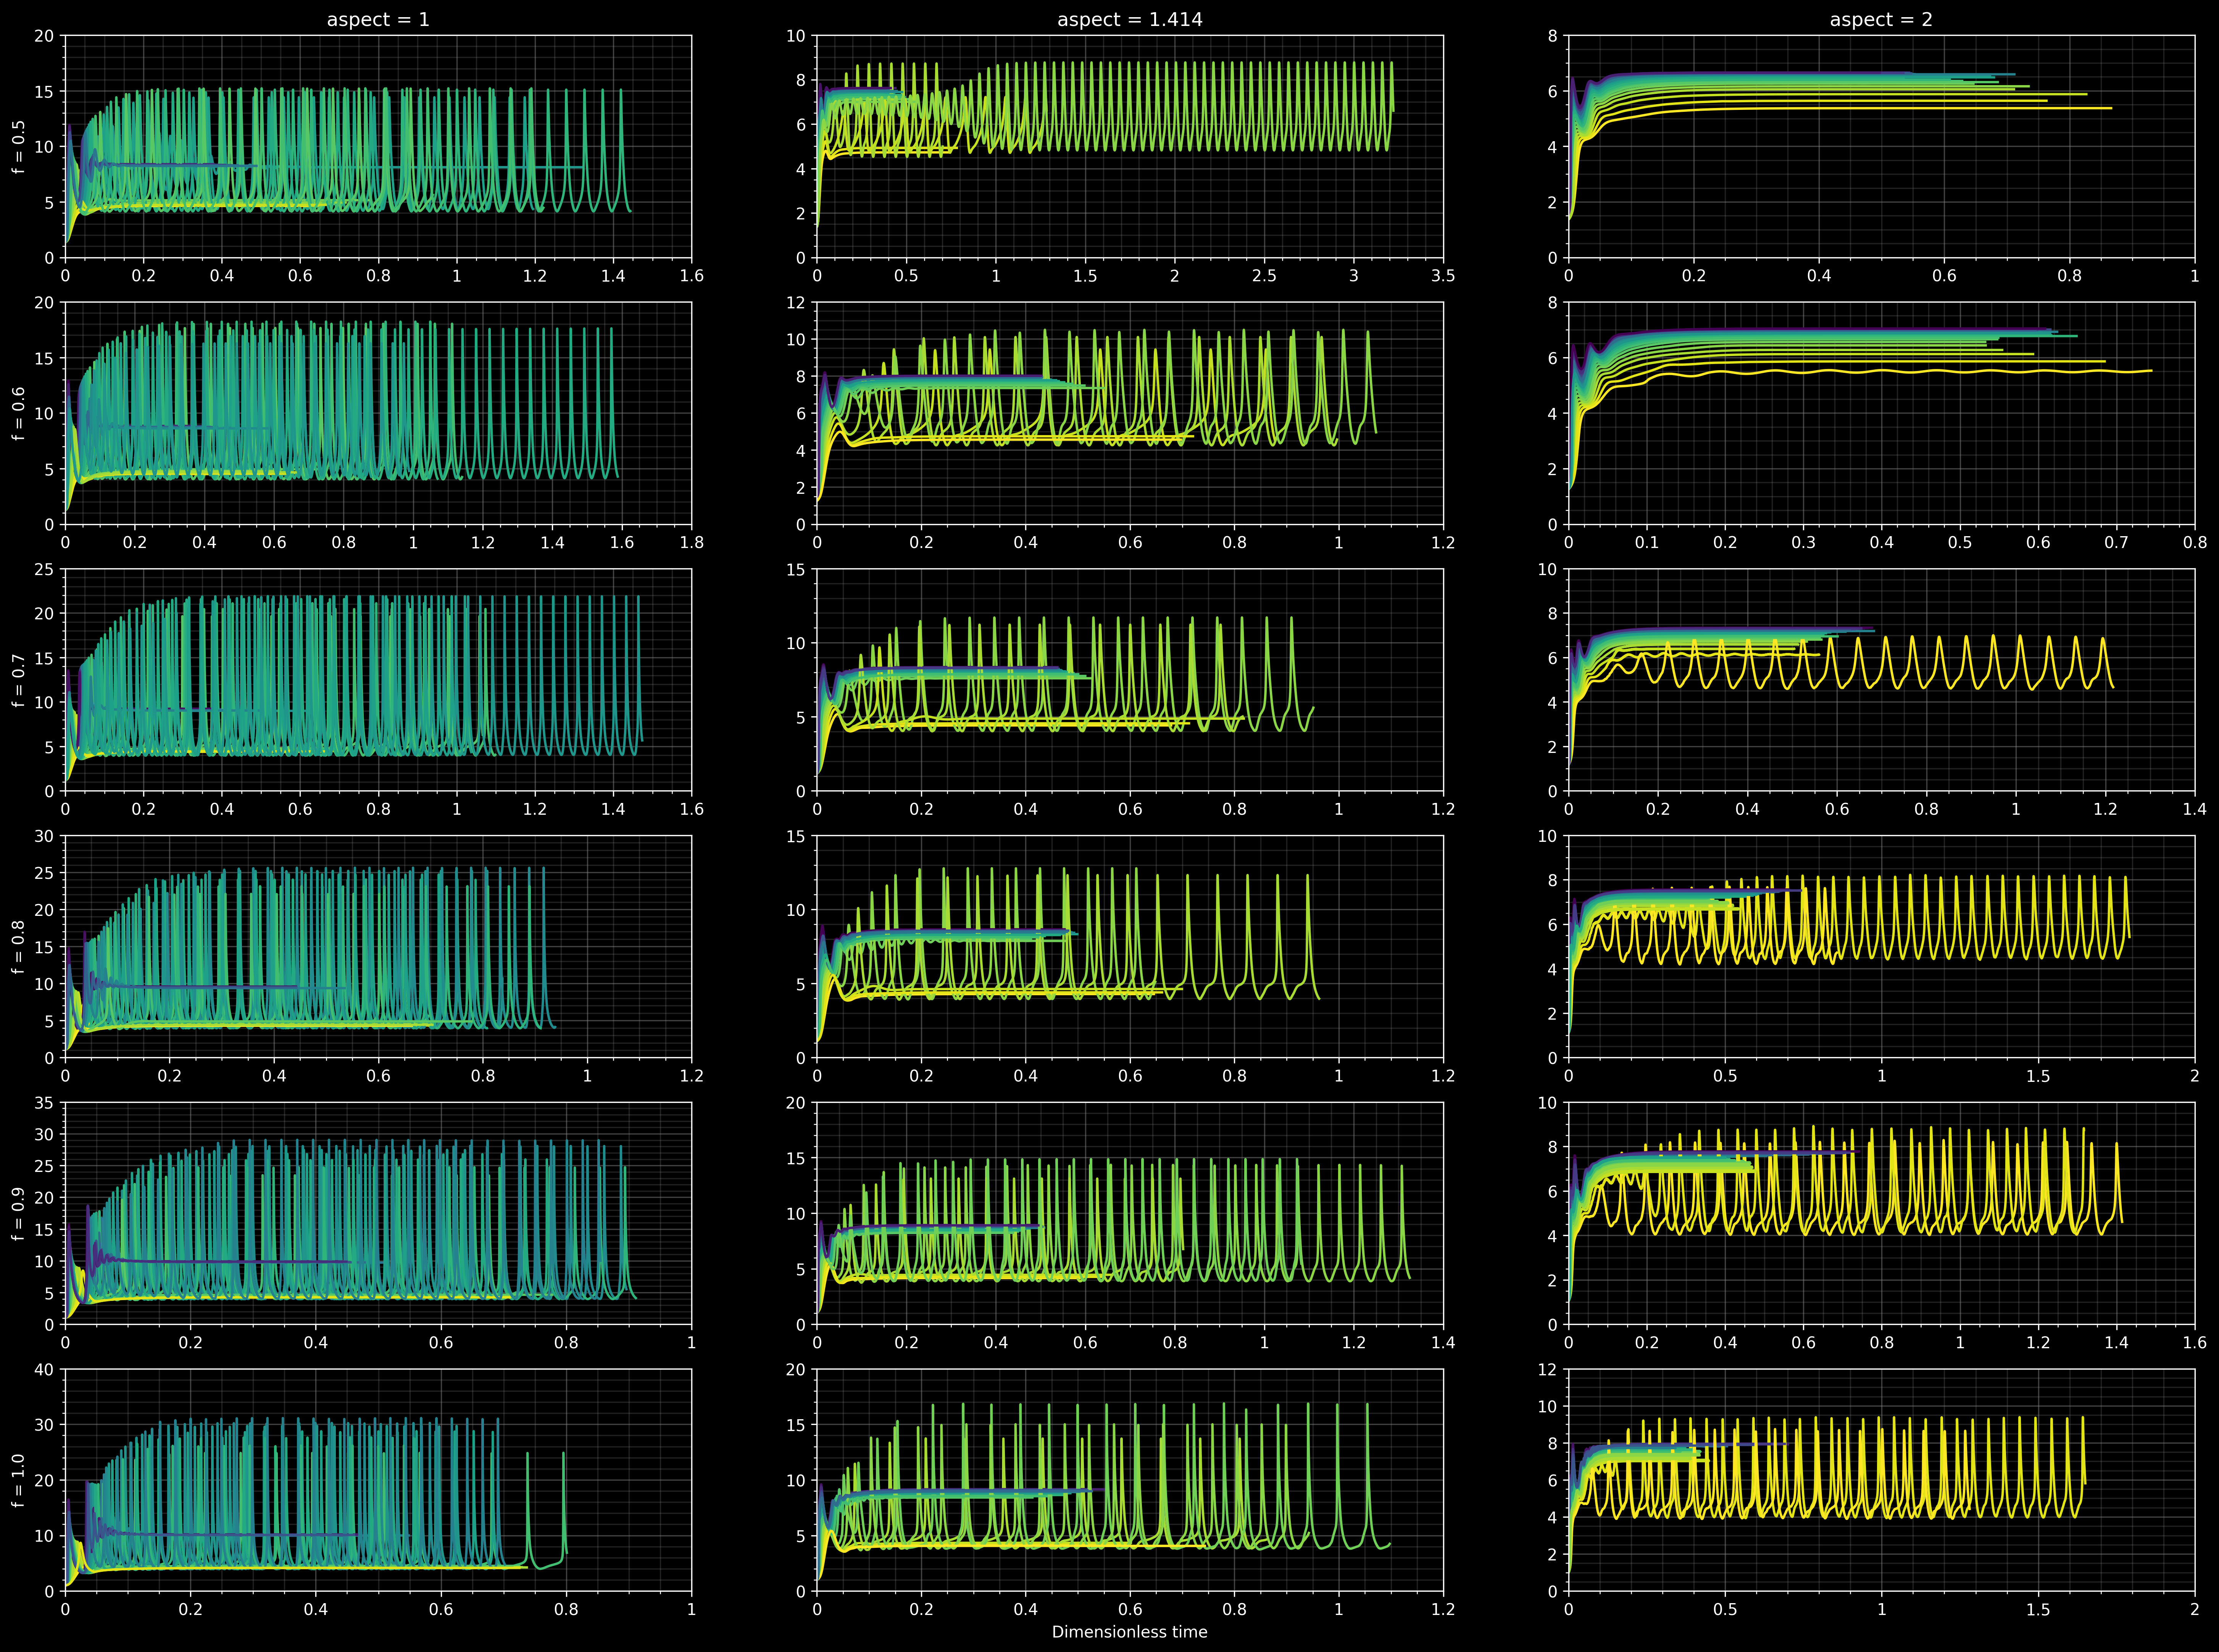

In [3]:
cut = \
    reader[F('aspect') < 3] \
    & reader[F('temperatureField') == '_built_peaskauslu-thoesfthuec']

canvas = Canvas(
    name = 'MS98plot',
#     title = 'MS98 - full model suite',
    dpi = 300,
    shape = (6, 3),
    size = (24, 18),
    facecolour = 'black',
    )

cmap = get_cmap('viridis')
for col, aspect in enumerate((1, 1.414, 2)):
    for row, f in enumerate((0.5, 0.6, 0.7, 0.8, 0.9, 1.0)):
        ax = canvas.make_ax((row, col))
        subcut = cut & reader[F('f') == f] & reader[F('aspect') == aspect]
        datas = reader[subcut : ('tauRef', 't', 'Nu')]
        for tauRef, t, Nu in datas.values():
            ax.line(t, Nu, c = cmap(normTau(tauRef)))
        if row == 0: ax.axes.title = f"aspect = {aspect}"
        if col == 0: ax.axes.y.label = f"f = {f}"
        ax.axes.colour = 'white'
        ax.grid.colour = 'grey'
        ax.ticks.colour = 'white'
canvas.axs[-1][1][0].axes.x.label = 'Dimensionless time'

canvas.show()